In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import EarlyStopping

from keras import optimizers

Using TensorFlow backend.


In [2]:
DATA_DIR = 'Data/object-detection-crowdai/'
labels = pd.read_csv(DATA_DIR + 'labels.csv', usecols=[0,1,2,3,4,5])
labels = labels[labels.Label == 'Truck']
# We only use images were one Truck is annotated
labels = labels[~labels.Frame.isin(labels.Frame[labels.Frame.duplicated()].values)]
labels.columns=['xmin', 'ymin', 'xmax', 'ymax', 'Frame', 'Label']
labels[30:50]

,xmin,ymin,xmax,ymax,Frame,Label
2073,644,504,775,603,1479498504973733356.jpg,Truck
2085,410,501,593,626,1479498505973664668.jpg,Truck
2098,4,460,260,648,1479498506973219901.jpg,Truck
2138,1213,519,1268,564,1479498508472371495.jpg,Truck
2152,1247,526,1294,567,1479498509474767371.jpg,Truck
2161,1238,512,1285,563,1479498508972700273.jpg,Truck
2186,1245,515,1286,571,1479498510458527314.jpg,Truck
2199,1242,523,1290,572,1479498510972486528.jpg,Truck
2220,1211,520,1266,579,1479498511973788598.jpg,Truck
2236,1180,515,1233,581,1479498512953888226.jpg,Truck


(1200, 1920, 3)
     xmin  ymin  xmax  ymax                    Frame  Label
575   986   561  1015   590  1479498416965787036.jpg  Truck
(1200, 1920, 3)
      xmin  ymin  xmax  ymax                    Frame  Label
2693  1455   486  1761   566  1479498541974858765.jpg  Truck


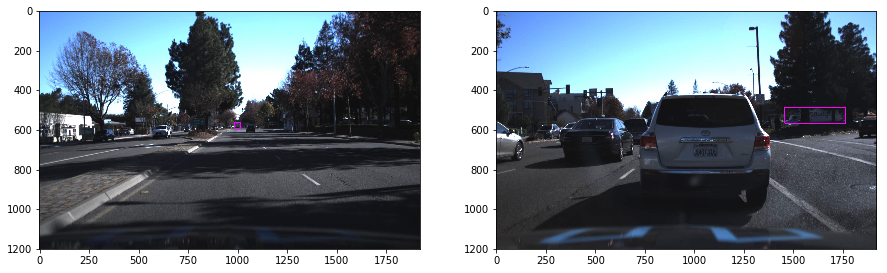

In [3]:
image_list = ['1479498416965787036.jpg',
              '1479498541974858765.jpg']

plt.figure(figsize=(15,15))
i=1
for image in image_list:
    plt.subplot(len(image_list), len(image_list), i)
    img_info = labels[labels.Frame == image]
    img = cv2.imread(DATA_DIR + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    cv2.rectangle(img, (img_info.xmin, img_info.ymin),(img_info.xmax, img_info.ymax), (255, 0 , 255), 4)
    print(img_info)
    plt.imshow(img)
    i+=1
plt.show()

In [4]:
X_train = labels.iloc[:1970]
X_val = labels.iloc[2000:]
print(X_train.shape)
print(X_val.shape)

(1970, 6)
(247, 6)


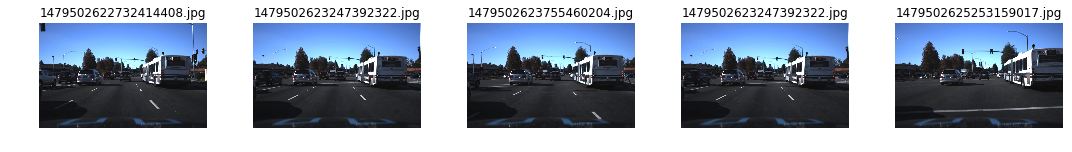

In [5]:
image_list = ['1479502622732414408.jpg',
            '1479502623247392322.jpg',
            '1479502623755460204.jpg',
            '1479502623247392322.jpg',
            '1479502625253159017.jpg']
n_images = len(image_list)

plt.figure(figsize=(15,15))
for i in range(n_images):
    plt.subplot(n_images, n_images, i+1)
    plt.title("{0}".format(image_list[i]))
    img = cv2.imread(DATA_DIR + image_list[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(img)
    plt.tight_layout() 
plt.show()

In [6]:
X_train = labels.iloc[:1970] # We've picked this frame because the car makes a right turn
X_val = labels.iloc[2000:]
print(X_train.shape)
print(X_val.shape)

(1970, 6)
(247, 6)


In [7]:
def IOU_calc(y_true, y_pred, smooth=0.9):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
img_rows = 200
img_cols = 200
img_channels = 3

model = Sequential()
model.add(Lambda(lambda x: (x / 255.) - 0.5, input_shape=(img_rows, img_cols, img_channels)))
model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

# Define optimizer and compile
opt = optimizers.Adam(lr=1e-8)
model.compile(optimizer=opt, loss='mse', metrics=[IOU_calc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [10]:
def batchgen(x, y, batch_size):
    # Create empty numpy arrays
    images = np.zeros((batch_size, img_rows, img_cols, img_channels))
    class_id = np.zeros((batch_size, 4))#len(y[0])))

    while 1:
        for n in range(batch_size):
            i = np.random.randint(len(x))
            
            x_ = x.Frame.iloc[i]
            x_ = cv2.imread(DATA_DIR + image)
            x_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            x_min = (x.iloc[i].xmin * (img_cols/1920)) / img_cols
            x_max = (x.iloc[i].xmax * (img_cols/1920)) / img_cols
            y_min = (x.iloc[i].ymin * (img_rows/1200)) / img_rows
            y_max = (x.iloc[i].ymax * (img_rows/1200)) / img_rows
            y_ = (x_min, y_min, x_max, y_max)            
            x_ = cv2.resize(x_, (img_cols, img_rows))
            images[n] = x_
            class_id[n] = y_
            yield images, class_id

In [15]:
callbacks = [EarlyStopping(monitor='val_IOU_calc', patience=2, verbose=0)]

In [16]:
batch_size = 5
n_epochs = 100
steps_per_epoch = 10
val_steps = len(X_val)//batch_size

train_generator = batchgen(X_train, _, batch_size)
val_generator = batchgen(X_val, _, batch_size)

history = model.fit_generator(train_generator, 
                               steps_per_epoch=steps_per_epoch, 
                               epochs=n_epochs, 
                               validation_data=val_generator,
                               validation_steps = val_steps,
                              callbacks=callbacks
                             )

Epoch 1/100
10/10 [==============================] - 28s 3s/step - loss: 0.0406 - IOU_calc: 0.5201 - val_loss: 0.0206 - val_IOU_calc: 0.5493
Epoch 2/100
10/10 [==============================] - 27s 3s/step - loss: 0.0328 - IOU_calc: 0.5437 - val_loss: 0.0145 - val_IOU_calc: 0.5651
Epoch 3/100
10/10 [==============================] - 28s 3s/step - loss: 0.0271 - IOU_calc: 0.5546 - val_loss: 0.0240 - val_IOU_calc: 0.5615
